In [1]:
import pybaseball
import pandas as pd
import numpy as np
import bs4
import requests
import matplotlib.pyplot as plt
import unicodedata
import seaborn as sns
import math
import matplotlib.patches as mpatches
from IPython.display import display
pybaseball.cache.enable()

In [2]:
import os
pd.set_option('display.max_columns',None)
os.getcwd()
os.chdir('C:\\Users\\npacchioli\\Desktop\\pyBaseball\\')
os.getcwd()

directory = 'C:\\Users\\npacchioli\\Desktop\\pyBaseball\\'

In [3]:
from pybaseball import playerid_lookup
from pybaseball import statcast_pitcher
from pybaseball import statcast_batter
from pybaseball import statcast
from pybaseball import pitching_stats

In [4]:
#get raw data for all pitchers

raw = statcast('2023-03-31','2023-08-23')

This is a large query, it may take a moment to complete


100%|██████████| 146/146 [02:15<00:00,  1.08it/s]


In [5]:
raw = raw.sort_values(by=['game_date', 'inning','at_bat_number','pitch_number'], ascending = [True, True,True,True])

In [6]:
raw = raw.dropna(subset=['release_speed','pfx_z'])

In [7]:
#create all the variables needed to calculate VAA

yO = 50
yf = 17/12
yFin = yO - yf

In [8]:
#first create vy_)

raw['vy_f'] = -np.sqrt((raw['vy0']**2) - (2* raw['ay']*yFin))
raw['t'] = (raw['vy_f'] - raw['vy0']) / raw['ay']
raw['vz_f'] = raw['vz0'] + (raw['az']*raw['t'])
raw['vaa'] = (np.arctan(raw['vz_f']/raw['vy_f'])*-1)*(180/np.pi)

In [9]:
raw['pfx_z'] = raw['pfx_z']*12
raw['pfx_x'] = raw['pfx_x']*12

#raw = raw.dropna(subset=['release_speed'])
#raw[['release_speed']] = raw[['release_speed']].astype('int64')

raw = raw.dropna(subset=['release_spin_rate'])
raw[['release_spin_rate']] = raw[['release_spin_rate']].astype('int64')

raw = raw.dropna(subset=['spin_axis'])
raw[['spin_axis']] = raw[['spin_axis']].astype('int64')



In [10]:
#let's create average fastball speed, to then compare to the breaking pitch
fastballs = raw.loc[raw['pitch_type'] == 'FF']

In [11]:
cut_bins_velo = [0,90,91,92,93,94,95,96,97,98,110]
cut_bins_pfz = [0,12,13,14,15,16,17,18,19,20,25]
vaa_bins = [-6,-5.75,-5.5,-5.25,-5,-4.75,-4.5,-4.25,-4,-3.75,-3.5]
vert_sz_bins = [.5,.75,1,1.25,1.5,1.75,2,2.25,2.5,2.75,3,3.25,3.5,3.75,4,10]
hor_sz_bins =  [-2.25,-2,-1.75,-1.5,-1.25,-1,-.75,-.5,-.25,0,.25,.5,.75,1,1.25,1.5,1.75,2,2.25]

fastballs['velo_bin'] = pd.cut(fastballs['release_speed'],bins = cut_bins_velo)
fastballs['plate_z_bin'] = pd.cut(fastballs['plate_z'], bins = vert_sz_bins)
fastballs['plate_x_bin'] = pd.cut(fastballs['plate_x'], bins = hor_sz_bins)
fastballs['pfx_z_bin'] = pd.cut(fastballs['pfx_z'],bins = cut_bins_pfz)
fastballs['vaa_bin'] = pd.cut(fastballs['vaa'], bins = vaa_bins)

C:\Users\npacchioli\AppData\Local\Temp\ipykernel_22172\2692304953.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fastballs['velo_bin'] = pd.cut(fastballs['release_speed'],bins = cut_bins_velo)
C:\Users\npacchioli\AppData\Local\Temp\ipykernel_22172\2692304953.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fastballs['plate_z_bin'] = pd.cut(fastballs['plate_z'], bins = vert_sz_bins)
C:\Users\npacchioli\AppData\Local\Temp\ipykernel_22172\2692304953.py:9: SettingWithCopyWarning: 
A value is trying to b

In [12]:
t = []

for i in fastballs['description']:
    if i == 'swinging_strike' or i == 'swinging_strike_blocked' or i == 'foul_tip':
        j = 1
    else:
        j = 0
        
    t.append(j)
    
q = []

for i in fastballs['description']:
    if i == 'called_strike':
        k = 1
    else:
        k = 0
        
    q.append(k)
    

fastballs['swstr'] = t
fastballs['called_str'] = q

fastballs['csw'] = np.where(fastballs['swstr'] + fastballs['called_str'] > 0, 1, 0)


C:\Users\npacchioli\AppData\Local\Temp\ipykernel_22172\3391330909.py:22: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fastballs['swstr'] = t
C:\Users\npacchioli\AppData\Local\Temp\ipykernel_22172\3391330909.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fastballs['called_str'] = q
C:\Users\npacchioli\AppData\Local\Temp\ipykernel_22172\3391330909.py:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

S

In [25]:
def plate_sort(df):

    ee = []
    for index, row in df.iterrows():
        plate_x = row['plate_x']
        plate_z = row['plate_z']
    
        if plate_x > -.25 and plate_x < .25 and plate_z > 2.5 and plate_z < 3.1:
            z = 1
        else:
            z = 0
            
        ee.append(z)
        
    df['middle_middle'] = ee
        
    return df

fastballs = plate_sort(fastballs)
fastballs_bip = plate_sort(fastballs_bip)
    

C:\Users\npacchioli\AppData\Local\Temp\ipykernel_22172\3449504200.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['middle_middle'] = ee
C:\Users\npacchioli\AppData\Local\Temp\ipykernel_22172\3449504200.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['middle_middle'] = ee


In [34]:
fastballs_bip = fastballs_bip.dropna(subset=['launch_speed_angle'])

In [35]:
def barrel(df):

    ee = []
    for index, row in df.iterrows():
        ba = row['launch_speed_angle']
        

    
        if ba == 6:
            z = 1
        else:
            z = 0 
            
        ee.append(z)
        
    df['barrel'] = ee
        
    return df

fastballs_bip = barrel(fastballs_bip)

C:\Users\npacchioli\AppData\Local\Temp\ipykernel_22172\1054383477.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['barrel'] = ee


In [14]:
fastballs_bip = fastballs.loc[fastballs['description'] == 'hit_into_play']

In [36]:
fastballs_bip.groupby(by='velo_bin').mean()

C:\Users\npacchioli\AppData\Local\Temp\ipykernel_22172\3368044237.py:1: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  fastballs_bip.groupby(by='velo_bin').mean()


,release_speed,release_pos_x,release_pos_z,batter,pitcher,spin_dir,spin_rate_deprecated,break_angle_deprecated,break_length_deprecated,zone,hit_location,balls,strikes,game_year,pfx_x,pfx_z,plate_x,plate_z,on_3b,on_2b,on_1b,outs_when_up,inning,hc_x,hc_y,tfs_deprecated,tfs_zulu_deprecated,fielder_2,umpire,sv_id,vx0,vy0,vz0,ax,ay,az,sz_top,sz_bot,hit_distance_sc,launch_speed,launch_angle,effective_speed,release_spin_rate,release_extension,game_pk,pitcher.1,fielder_2.1,fielder_3,fielder_4,fielder_5,fielder_6,fielder_7,fielder_8,fielder_9,release_pos_y,estimated_ba_using_speedangle,estimated_woba_using_speedangle,woba_value,woba_denom,babip_value,iso_value,launch_speed_angle,at_bat_number,pitch_number,home_score,away_score,bat_score,fld_score,post_away_score,post_home_score,post_bat_score,post_fld_score,spin_axis,delta_home_win_exp,delta_run_exp,vy_f,t,vz_f,vaa,swstr,called_str,csw,middle_middle,barrel
velo_bin,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
"(0, 90]",88.705346,0.21841,5.742077,630492.621659,588621.49623,<NA>,<NA>,<NA>,<NA>,5.4366,6.468981,1.056203,0.884167,2023.0,1.25231,14.214859,-0.01806,2.674969,638601.764706,632919.504065,629321.358491,0.826594,4.387252,127.848195,115.171132,<NA>,<NA>,615865.268677,<NA>,<NA>,-0.804168,-129.025054,-3.950257,1.345723,25.970367,-18.284661,3.344702,1.588917,196.178571,89.918163,18.706648,89.179027,2182.315284,6.52769,717879.242632,588621.49623,615865.268677,614435.25634,646810.59904,626920.167238,649655.777245,639982.795065,653625.12817,637279.772447,53.973304,0.350302,0.42351,0.442666,0.990404,0.289239,0.305003,3.439342,33.745716,3.080877,1.875942,2.318026,2.343386,1.850583,2.411241,1.976011,2.536669,1.850583,177.391364,0.00119,0.101237,-118.844918,0.392105,-11.125703,-5.346699,0.0,0.0,0.0,0.161069,0.115147
"(90, 91]",90.603251,-0.012926,5.785017,628777.584605,620594.836762,<NA>,<NA>,<NA>,<NA>,5.543464,6.593571,1.114134,0.877903,2023.0,-0.261818,15.06856,-0.025448,2.658686,628664.864198,626924.258216,630775.913876,0.834107,4.312541,126.089436,114.938679,<NA>,<NA>,616653.035833,<NA>,<NA>,0.016884,-131.787169,-4.584102,-0.258492,27.429535,-16.761144,3.346198,1.587193,199.767287,90.527405,21.372263,91.057465,2193.939615,6.537492,717899.556072,620594.836762,616653.035833,619343.584605,642720.397478,623636.787658,638897.742535,638340.179827,654720.966158,639548.765096,53.962104,0.33529,0.408422,0.412243,0.994028,0.270073,0.287989,3.47777,33.158593,3.126078,1.923026,2.213006,2.180491,1.955541,2.28998,2.001327,2.335766,1.955541,181.119443,0.001571,0.054633,-121.25088,0.38401,-11.019853,-5.190928,0.0,0.0,0.0,0.138686,0.122760
"(91, 92]",91.597713,-0.391878,5.836831,630867.847658,624326.984508,<NA>,<NA>,<NA>,<NA>,5.347473,6.576559,1.093692,0.936186,2023.0,-1.523969,15.278466,-0.01997,2.695267,632347.962162,630488.408072,630342.498108,0.835116,4.372187,128.926894,114.385385,<NA>,<NA>,614739.361859,<NA>,<NA>,1.216673,-133.230685,-4.838506,-1.768166,28.020768,-16.161646,3.344943,1.587459,196.530281,90.890926,19.898561,91.98553,2225.879011,6.494504,717865.008115,624326.984508,614739.361859,616357.96422,639946.976392,627224.754703,636714.118775,640991.953154,653953.710439,640170.684987,54.005186,0.34434,0.417369,0.428643,0.994836,0.286979,0.288823,3.467355,33.58945,3.174843,1.957211,2.257101,2.094799,2.119513,2.35817,2.044264,2.282921,2.119513,187.090373,-0.00021,0.083863,-122.584353,0.379841,-10.975864,-5.11469,0.0,0.0,0.0,0.145703,0.117669
"(92, 93]",92.575871,-0.592288,5.849687,627383.141876,624674.247902,<NA>,<NA>,<NA>,<NA>,5.646834,6.600597,1.143656,0.99644,2023.0,-1.929275,15.363539,-0.003748,2.699522,629745.612805,632447.70418,629282.607826,0.884566,4.428935,127.915715,114.143685,<NA>,<NA>,615582.98983,<NA>,<NA>,1.858745,-134.645261,-5.045815,-2.357656,28.780733,-15.695531,3.350338,1.590763,197.031799,90.431172,19.441648,92.854171,2256.521993,6.457731,717846.544368,624674.247902,615582.98983,612849.573608,636057.146707,628161.448258,638153.501907,6402

In [13]:
tw = fastballs['release_pos_z']
tz = fastballs['vaa']

tw = tw.astype('float64')
tz = tz.astype('float64')

fastballs['vaa'] = fastballs['vaa'].astype('float64')
fastballs['pfx_z'] = fastballs['pfx_z'].astype('float64')
fastballs['csw'] = fastballs['csw'].astype('float64')

tw.corr(tz)


C:\Users\npacchioli\AppData\Local\Temp\ipykernel_22828\931149449.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fastballs['vaa'] = fastballs['vaa'].astype('float64')
C:\Users\npacchioli\AppData\Local\Temp\ipykernel_22828\931149449.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fastballs['pfx_z'] = fastballs['pfx_z'].astype('float64')
C:\Users\npacchioli\AppData\Local\Temp\ipykernel_22828\931149449.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try

-0.32711481482956756

In [19]:
x = pd.pivot_table(fastballs, index='velo_bin',columns = 'pfx_z_bin', values = 'swstr', aggfunc =lambda x: np.mean(x)*100
                   ,fill_value = 0)
#x = x.reset_index()
#x
x


pfx_z_bin,"(0, 12]","(12, 13]","(13, 14]","(14, 15]","(15, 16]","(16, 17]","(17, 18]","(18, 19]","(19, 20]","(20, 25]"
velo_bin,,,,,,,,,,
"(0, 90]",8.528302,6.122449,7.216495,6.547619,5.416667,7.925072,6.932153,7.894737,7.629428,8.423913
"(90, 91]",7.722513,7.443366,8.829569,7.417582,5.703883,7.028360,7.923169,6.720000,7.424594,6.395349
"(91, 92]",8.205521,8.750000,6.761178,9.555069,8.071429,7.266667,8.208955,9.411765,10.810811,12.326656
"(92, 93]",8.002371,8.571429,10.051737,11.033797,8.755324,8.970393,9.426752,10.150376,10.196445,11.066800
"(93, 94]",7.829181,8.132530,9.718499,8.798646,9.141583,9.874873,9.323703,10.686320,12.149533,13.458111
"(94, 95]",7.440667,8.940397,7.681053,9.614570,10.466813,11.418463,11.111111,11.704947,12.404181,15.391791
"(95, 96]",7.979120,10.012063,10.040486,10.368893,11.287554,10.803738,11.861379,12.890431,14.472608,15.010352
"(96, 97]",8.427544,10.468750,10.000000,11.626298,12.831325,13.495575,12.255679,14.592593,16.323907,17.863105
"(97, 98]",7.258065,10.975610,9.838998,11.672278,13.320080,15.398551,14.558059,16.798942,16.389549,19.827586


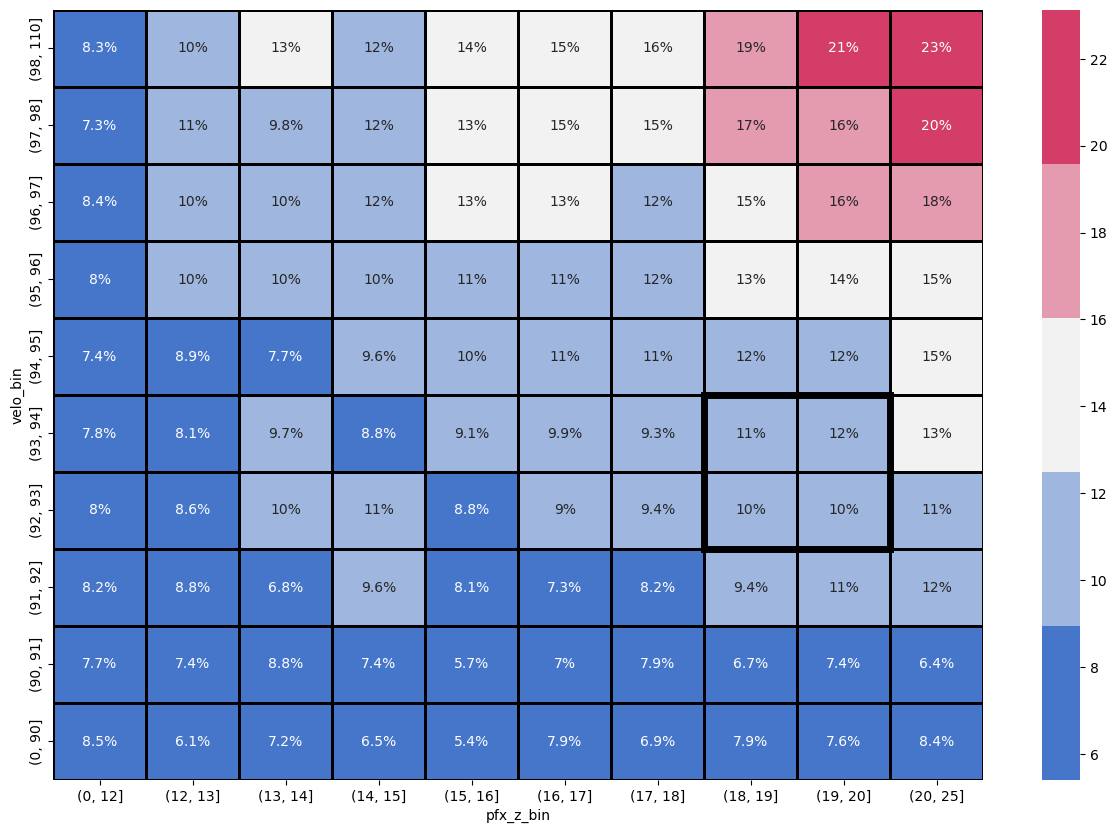

In [28]:
from matplotlib.patches import Rectangle

fig, ax = plt.subplots(figsize = (15,10))

cmap = sns.diverging_palette(255,0, sep = 10,n=5)

g = sns.heatmap(x, cmap = cmap, linewidths = 1, linecolor = 'black', annot = True)

for text in g.texts:
    text.set_text(text.get_text()+'%')
g.invert_yaxis()

g.add_patch(Rectangle((7,3),2,2, fill= False, edgecolor = 'black', lw = 5))


In [26]:
topZone = fastballs.loc[fastballs['plate_z'] > 2.5]

In [27]:
y = pd.pivot_table(topZone, index='velo_bin',columns = 'pfx_z_bin', values = 'csw', aggfunc = 'mean'
                   ,fill_value = 0)
#x = x.reset_index()
#x
y

pfx_z_bin,"(0, 12]","(12, 13]","(13, 14]","(14, 15]","(15, 16]","(16, 17]","(17, 18]","(18, 19]","(19, 20]","(20, 25]"
velo_bin,,,,,,,,,,
"(0, 90]",0.264831,0.243478,0.214815,0.236842,0.269608,0.255708,0.255814,0.288462,0.289916,0.334975
"(90, 91]",0.234450,0.171429,0.206667,0.258065,0.221429,0.199413,0.231003,0.267241,0.215054,0.281250
"(91, 92]",0.229814,0.173184,0.278571,0.230769,0.236641,0.219081,0.240589,0.232704,0.232787,0.235119
"(92, 93]",0.202564,0.234201,0.227603,0.231746,0.219061,0.239950,0.258352,0.238924,0.257709,0.302734
"(93, 94]",0.218341,0.228916,0.193548,0.258732,0.260306,0.268898,0.257473,0.276692,0.250000,0.281867
"(94, 95]",0.230570,0.163880,0.241015,0.233732,0.251765,0.245128,0.253968,0.256374,0.291755,0.266949
"(95, 96]",0.250836,0.197917,0.250000,0.255533,0.237216,0.242568,0.276451,0.284314,0.285333,0.285326
"(96, 97]",0.172222,0.184211,0.231884,0.221264,0.204327,0.274611,0.286154,0.264706,0.263780,0.296804
"(97, 98]",0.133333,0.227848,0.265152,0.248963,0.270386,0.299145,0.260442,0.286738,0.358824,0.404580


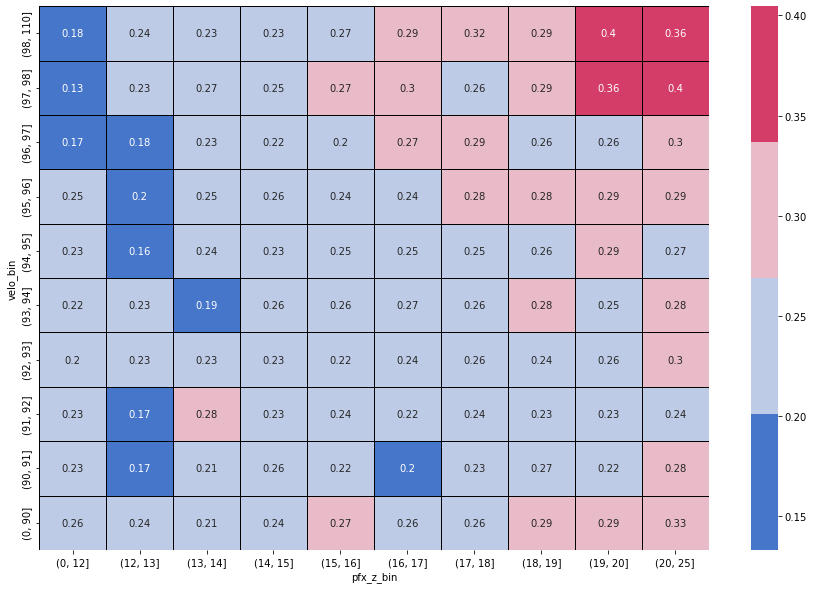

In [28]:
from matplotlib.patches import Rectangle

fig, ax = plt.subplots(figsize = (15,10))

cmap = sns.diverging_palette(255,0, sep = 10,n=4)

g = sns.heatmap(y, cmap = cmap, linewidths = 1, linecolor = 'black', annot = True)
g.invert_yaxis()
#g.add_patch(Rectangle((6,5),6,8, fill= False, edgecolor = 'black', lw = 5))

In [31]:
zulu = pd.pivot_table(topZone, index = 'player_name',columns = 'pfx_z_bin',values = 'swstr', fill_value = 0)
zulu = zulu.reset_index()
zulu

pfx_z_bin,player_name,"(0, 12]","(12, 13]","(13, 14]","(14, 15]","(15, 16]","(16, 17]","(17, 18]","(18, 19]","(19, 20]","(20, 25]"
0,"Abbott, Cory",0.000000,0.0,0.000000,0.000000,0.047619,0.075000,0.094340,0.000000,0.125,0.200000
1,"Abreu, Albert",0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000,0.000000
2,"Abreu, Bryan",0.000000,0.0,0.333333,0.500000,0.000000,0.363636,0.071429,0.363636,0.000,0.000000
3,"Acevedo, Domingo",0.230769,0.0,0.200000,0.272727,0.000000,0.500000,0.500000,0.000000,0.000,0.000000
4,"Adam, Jason",0.000000,1.0,0.000000,0.000000,0.142857,0.181818,0.214286,0.333333,0.250,0.454545
...,...,...,...,...,...,...,...,...,...,...,...
525,"Young, Alex",0.000000,0.0,0.500000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000,0.000000
526,"Zastryzny, Rob",0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.125000,0.000000,0.000,0.000000
527,"Zeuch, T.J.",0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000,0.000000
528,"Zimmermann, Bruce",0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000,0.000000


In [32]:
zulu.to_excel(directory + 'fbUpZone.xlsx')

In [34]:
firstPitch = fastballs.loc[fastballs['balls'] == 0]
firstPitch = firstPitch.loc[firstPitch['strikes'] == 0]

In [51]:
z = pd.pivot_table(firstPitch, index='plate_z_bin',columns = 'plate_x_bin', values = 'csw', aggfunc = 'mean'
                   ,fill_value = 0)
#x = x.reset_index()
#x
z

plate_x_bin,"(-2.25, -2.0]","(-2.0, -1.75]","(-1.75, -1.5]","(-1.5, -1.25]","(-1.25, -1.0]","(-1.0, -0.75]","(-0.75, -0.5]","(-0.5, -0.25]","(-0.25, 0.0]","(0.0, 0.25]","(0.25, 0.5]","(0.5, 0.75]","(0.75, 1.0]","(1.0, 1.25]","(1.25, 1.5]","(1.5, 1.75]","(1.75, 2.0]","(2.0, 2.25]"
plate_z_bin,,,,,,,,,,,,,,,,,,
"(0.5, 0.75]",0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00,0,0
"(0.75, 1.0]",0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.050000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00,0,0
"(1.0, 1.25]",0,0.000000,0.000000,0.000000,0.000000,0.000000,0.052632,0.000000,0.069767,0.047619,0.000000,0.034483,0.000000,0.000000,0.000000,0.00,0,0
"(1.25, 1.5]",0,0.000000,0.000000,0.000000,0.000000,0.096774,0.227273,0.210526,0.218182,0.285714,0.240741,0.136364,0.054545,0.000000,0.000000,0.00,0,0
"(1.5, 1.75]",0,0.000000,0.000000,0.000000,0.025000,0.383333,0.546667,0.698630,0.693182,0.640351,0.644860,0.577778,0.280000,0.015873,0.000000,0.00,0,0
"(1.75, 2.0]",0,0.000000,0.000000,0.030303,0.066667,0.562500,0.736842,0.798658,0.681818,0.625698,0.738095,0.783217,0.485714,0.046154,0.000000,0.00,0,0
"(2.0, 2.25]",0,0.000000,0.000000,0.000000,0.064935,0.526316,0.650685,0.576271,0.560606,0.585253,0.586538,0.696133,0.528846,0.105263,0.000000,0.00,0,0
"(2.25, 2.5]",0,0.000000,0.000000,0.000000,0.155556,0.528986,0.630303,0.543933,0.506383,0.554622,0.561947,0.650538,0.520270,0.142857,0.035714,0.00,0,0
"(2.5, 2.75]",0,0.000000,0.041667,0.000000,0.150000,0.488722,0.575269,0.513043,0.488215,0.488189,0.465587,0.576271,0.454545,0.141304,0.065217,0.05,0,0


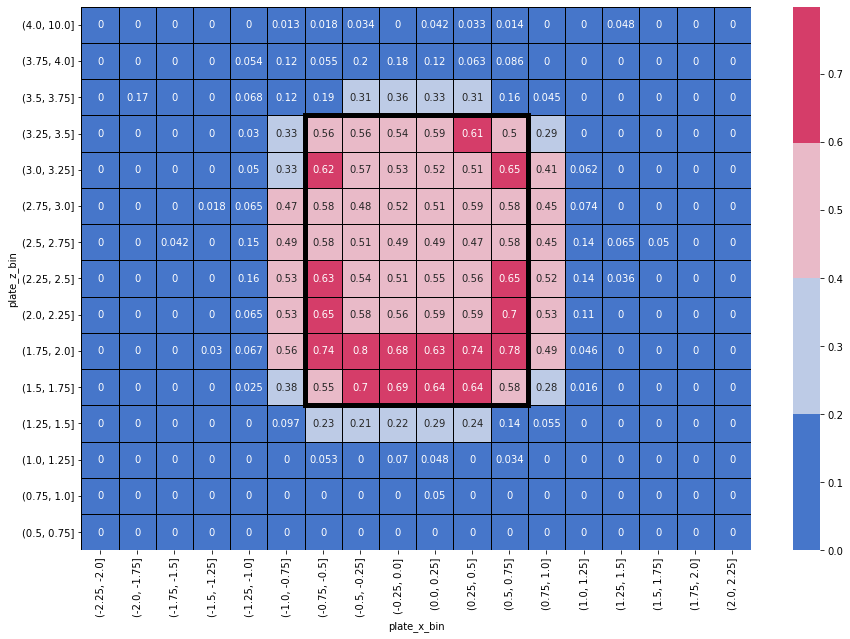

In [146]:
from matplotlib.patches import Rectangle

fig, ax = plt.subplots(figsize = (15,10))

cmap = sns.diverging_palette(255,0, sep = 10,n=4)

g = sns.heatmap(z, cmap = cmap, linewidths = 1, linecolor = 'black', annot = True)
g.invert_yaxis()
g.add_patch(Rectangle((6,4),6,8, fill= False, edgecolor = 'black', lw = 5))

In [47]:
xx = pd.pivot_table(firstPitch,index = 'player_name', values = 'csw')

xx = xx.reset_index()
xx = xx.sort_values(by='csw',ascending = False)
xx.head(50)

,player_name,csw
219,"Junis, Jakob",1.000000
172,"Graterol, Brusdar",1.000000
328,"Nittoli, Vinny",1.000000
17,"Ashby, Aaron",1.000000
134,"Fernández, Junior",1.000000
446,"Tarnok, Freddy",1.000000
498,"Wisler, Matt",1.000000
9,"Alvarez, R.J.",1.000000
256,"Loáisiga, Jonathan",1.000000
120,"Eflin, Zach",1.000000


In [306]:
csw = pd.pivot_table(fastballs, index='player_name',values= 'swstr', aggfunc = 'count')
csw = csw.reset_index()
csw = csw.sort_values(by='swstr',ascending = False)

lb = csw

csw2 = pd.pivot_table(fastballs, index='player_name',values= 'swstr', aggfunc = 'mean')
csw2 = csw2.reset_index()
csw2 = csw2.sort_values(by='swstr',ascending = False)

In [307]:
lb = pd.merge(lb,csw2,on = 'player_name',how = 'left')

In [309]:
lb = lb.loc[lb['swstr_x'] > 499]

In [311]:
lb = lb.sort_values(by='swstr_y', ascending = False)
lb.head(50)

,player_name,swstr_x,swstr_y
126,"Sewald, Paul",644,0.184783
83,"Hendriks, Liam",761,0.182654
109,"May, Trevor",673,0.181278
146,"Maton, Phil",577,0.175043
53,"Woodruff, Brandon",945,0.172487
112,"Manoah, Alek",668,0.170659
41,"Lynn, Lance",1051,0.170314
70,"Green, Chad",827,0.169287
166,"Bednar, David",520,0.167308
147,"Littell, Zack",574,0.165505


In [90]:
choose_player = 'Kremer, Dean'
choose_player2 = 'Gibson, Kyle'

fpC = fastballs.loc[(fastballs['player_name'] == choose_player) | (fastballs['player_name'] == choose_player2)]

In [91]:
zz = pd.pivot_table(fpC, index='pfx_z_bin',columns = 'velo_bin', values = 'swstr', aggfunc = 'mean' ,fill_value = 0)
#x = x.reset_index()
#x
zz

velo_bin,"(0, 90]","(90, 91]","(91, 92]","(92, 93]","(93, 94]","(94, 95]","(95, 96]","(96, 97]"
pfx_z_bin,,,,,,,,
"(0, 12]",0,0,0.00,0.000000,0.000000,0.000000,0.000000,0.0
"(12, 13]",0,0,0.00,0.000000,0.000000,0.000000,0.000000,0.0
"(13, 14]",0,0,0.00,0.000000,0.000000,0.000000,0.000000,0.0
"(14, 15]",0,0,0.00,0.000000,0.090909,0.222222,0.000000,0.0
"(15, 16]",0,0,0.00,0.090909,0.111111,0.125000,0.000000,0.0
"(16, 17]",0,0,0.00,0.000000,0.000000,0.105263,0.058824,0.5
"(17, 18]",0,0,0.25,0.105263,0.071429,0.071429,0.250000,0.0
"(18, 19]",0,0,0.00,0.000000,0.142857,0.166667,0.000000,0.0
"(19, 20]",0,0,0.00,0.000000,0.000000,0.000000,0.000000,0.0


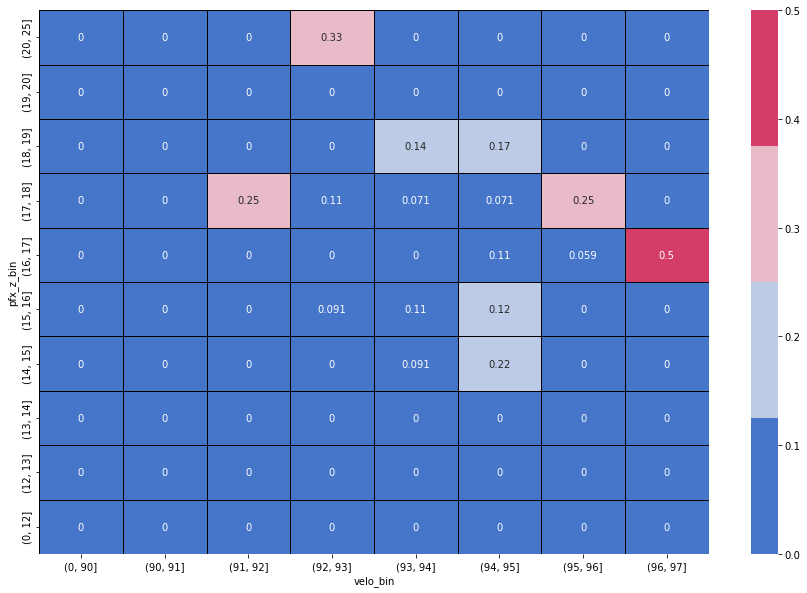

In [92]:
from matplotlib.patches import Rectangle

fig, ax = plt.subplots(figsize = (15,10))

cmap = sns.diverging_palette(255,0, sep = 10,n=4)

g = sns.heatmap(zz, cmap = cmap, linewidths = 1, linecolor = 'black', annot = True)
g.invert_yaxis()
#g.add_patch(Rectangle((5,4),6,8, fill= False, edgecolor = 'black', lw = 5))

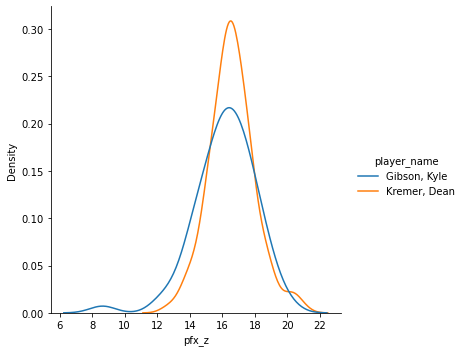

In [93]:
fpC = fpC.reset_index()

sns.displot(data = fpC, x = 'pfx_z', kind = 'kde', hue = 'player_name', common_norm = False)

In [109]:
raw['first_pitch'] = np.where(raw['balls'] + raw['strikes'] > 0, 0 ,1)

In [111]:
raw = raw.sort_values(by = ['player_name','game_date', 'inning','at_bat_number'], ascending = [True, True, True,True])

In [117]:
raw['first_pitch_FF'] = np.where((raw['first_pitch'] == 1) & (raw['pitch_type'] == 'FF'),1,0)

In [133]:
jz = []

for i in raw['pitch_number']:
    
        if raw.iloc[i+1]['pitch_number'] == 1:
            j = 1
        else:
            j = 0
            
        jz.append(j)

In [137]:
raw['end_of_AB'] =jz